In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
esg_scores = pd.read_csv('/content/drive/MyDrive/MIAX/TFM/AAA RED NEURONAL/ESG_SCORES.csv')

In [ ]:
path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/EMBEDDINGS.pkl"
embeddings = pd.read_pickle(path)

In [ ]:
news_press = pd.read_csv('/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/NEWS_+_PRESS_ESG_definitivo.csv')

In [ ]:
input_path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/WINDOWS.pkl"

with open(input_path, "rb") as f:
    data = pickle.load(f)

X = data["X"]
y = data["y"]
tickers = data["tickers"]
categories = data["categories"]
target_dates = data["target_dates"]

print(f"Ventanas cargadas: {len(X)}")
print(f"Ejemplo de forma de una ventana: {X[0].shape}")
print(f"Ejemplo de score (y[0]): {y[0]}")

Ventanas cargadas: 63401
Ejemplo de forma de una ventana: (90, 101)
Ejemplo de score (y[0]): None


In [ ]:
esg_scores["date"] = pd.to_datetime(esg_scores["date"])
esg_df = esg_scores.rename(columns={
    "symbol": "ticker",
    "environmentalScore": "env",
    "socialScore": "soc",
    "governanceScore": "gov"
})
windows_df = pd.DataFrame({
    "index": range(len(X)),
    "ticker": tickers,
    "category": categories,
    "target_date": pd.to_datetime(target_dates)
})
esg_long = pd.melt(
    esg_df,
    id_vars=["ticker", "date"],
    value_vars=["env", "soc", "gov"],
    var_name="category",
    value_name="esg_score"
)
category_map = {
    "env": "Environmental",
    "soc": "Social",
    "gov": "Governance"
}
esg_long["category"] = esg_long["category"].map(category_map)

# Matching Windows with Official ESG Scores

In this step, we associate each 90-day window with its corresponding official ESG score.

Matching logic:
- For each window, identify the closest available ESG score **before or exactly at** the window's target date.
- Allow a maximum **tolerance of 90 days** between the score date and the window target date.
- If no valid ESG score is found within the tolerance, the window is discarded.

Justification for 90-day tolerance:
- ESG scores are updated quarterly and are relatively stable.
- Allowing slight flexibility ensures more windows can be used without introducing significant misalignment.

In [ ]:
max_tolerancia_dias = 90
y_new = [None] * len(X)

esg_long = esg_long.sort_values(["ticker", "category", "date"])
windows_df = windows_df.sort_values(["ticker", "category", "target_date"]).reset_index(drop=True)

esg_grouped = esg_long.groupby(["ticker", "category"])
for i, row in tqdm(windows_df.iterrows(), total=len(windows_df), desc="Buscando ESG scores tolerantes"):

    ticker = row["ticker"]
    category = row["category"]
    target_date = row["target_date"]

    if (ticker, category) not in esg_grouped.groups:
        continue

    esg_subset = esg_grouped.get_group((ticker, category))
    valid_scores = esg_subset[esg_subset["date"] <= target_date]

    if valid_scores.empty:
        continue
    closest_score = valid_scores.iloc[-1]
    dias_diferencia = (target_date - closest_score["date"]).days

    if dias_diferencia <= max_tolerancia_dias:
        y_new[i] = closest_score["esg_score"]

y = np.array(y_new)
print(f"Total ventanas con score ESG asignado: {np.sum(y != None)}")

Buscando ESG scores tolerantes:   0%|          | 0/63401 [00:00<?, ?it/s]

Total ventanas con score ESG asignado: 51489


In [ ]:
train_df = pd.DataFrame({
    "ticker": tickers,
    "category": categories,
    "target_date": pd.to_datetime(target_dates),
    "esg_score": y
})

train_df = train_df[train_df["esg_score"].notna()]

In [ ]:
group_counts = train_df.groupby(["ticker", "target_date"])["category"].nunique().reset_index()

incompletos = group_counts[group_counts["category"] < 3]
print(f"Total de combinaciones incompletas (menos de 3 categorías): {len(incompletos)}")
print("Ejemplos:")
display(incompletos.head())

completos = group_counts[group_counts["category"] == 3]
print(f"Combinaciones completas (3 ventanas por fecha): {len(completos)}")

Total de combinaciones incompletas (menos de 3 categorías): 21649
Ejemplos:


,ticker,target_date,category
0,AAPL,2020-06-07,1
1,AAPL,2020-06-08,2
2,AAPL,2020-06-09,2
3,AAPL,2020-06-10,2
4,AAPL,2020-06-11,2


Combinaciones completas (3 ventanas por fecha): 6908


In [ ]:
merged = windows_df.merge(
    esg_long,
    left_on=["ticker", "category", "target_date"],
    right_on=["ticker", "category", "date"],
    how="inner"
)

In [ ]:
X_filtered = X[merged["index"]]
y_filtered = merged["esg_score"].values
tickers_filtered = merged["ticker"].values
categories_filtered = merged["category"].values
dates_filtered = merged["target_date"].values

In [ ]:
mask_valid = pd.Series(y).notna()

X_filtered = np.array(X)[mask_valid.values]
y_filtered = np.array(y)[mask_valid.values]
tickers_filtered = np.array(tickers)[mask_valid.values]
categories_filtered = np.array(categories)[mask_valid.values]
dates_filtered = pd.to_datetime(np.array(target_dates))[mask_valid.values]

In [ ]:
df_filtered = pd.DataFrame({
    "ticker": tickers_filtered,
    "category": categories_filtered,
    "target_date": dates_filtered,
    "esg_score": y_filtered
})

empresa = "AAPL"
fecha = pd.to_datetime("2022-03-26")

df_check = df_filtered[
    (df_filtered["ticker"] == empresa) &
    (df_filtered["target_date"] == fecha)
]

print(f"Ventanas encontradas para {empresa} el {fecha.date()}: {len(df_check)}")
display(df_check)

Ventanas encontradas para AAPL el 2022-03-26: 3


,ticker,category,target_date,esg_score
534,AAPL,Environmental,2022-03-26,72.39
2080,AAPL,Governance,2022-03-26,65.05
3680,AAPL,Social,2022-03-26,54.17


In [ ]:
esg_scores.head(15)

,date,acceptedDate,symbol,cik,companyName,formType,environmentalScore,socialScore,governanceScore,ESGScore,url
0,2024-12-28,2025-01-30,AAPL,320193,Apple Inc.,8-K,52.52,45.18,60.74,52.81,https://www.sec.gov/Archives/edgar/data/320193...
1,2024-09-28,2024-11-01,AAPL,320193,Apple Inc.,10-K,68.47,47.02,60.80,58.76,https://www.sec.gov/Archives/edgar/data/320193...
2,2024-06-29,2024-08-01,AAPL,320193,Apple Inc.,8-K,52.37,44.70,60.48,52.52,https://www.sec.gov/Archives/edgar/data/320193...
3,2024-03-30,2024-05-02,AAPL,320193,Apple Inc.,10-Q,72.07,49.55,61.63,61.08,https://www.sec.gov/Archives/edgar/data/320193...
4,2023-12-30,2024-02-01,AAPL,320193,Apple Inc.,10-Q,72.07,49.38,61.51,60.99,https://www.sec.gov/Archives/edgar/data/320193...
5,2023-09-30,2023-11-02,AAPL,320193,Apple Inc.,10-K,68.71,47.30,60.72,58.91,https://www.sec.gov/Archives/edgar/data/320193...
6,2023-07-01,2023-08-03,AAPL,320193,Apple Inc.,10-Q,72.79,55.16,66.14,64.70,https://www.sec.gov/Archives/edgar/data/320193...
7,2023-04-01,2023-05-04,AAPL,320193,Apple Inc.,10-Q,72.79,55.23,65.73,64.59,https://www.sec.gov/Archives/edgar/data/320193...
8,2022-12-31,2023-02-02,AAPL,320193,Apple Inc.,10-Q,72.39,53.49,65.62,63.83,https://www.sec.gov/Archives/edgar/data/320193...
9,2022-09-24,2022-10-27,AAPL,320193,Apple Inc.,10-K,68.80,47.73,61.26,59.26,https://www.sec.gov/Archives/edgar/data/320193...


In [ ]:
empresa = "AAPL"
df_empresa = df_filtered[df_filtered["ticker"] == empresa]
conteo = (
    df_empresa
    .groupby("target_date")["category"]
    .nunique()
    .reset_index()
)

fechas_completas = conteo[conteo["category"] == 3]["target_date"].sort_values()

print(f"Fechas con las 3 categorías ESG para {empresa}:")
display(fechas_completas.head())

if not fechas_completas.empty:
    fecha = fechas_completas.iloc[0]
    print(f"Detalles para {empresa} el {fecha.date()}:")
    display(df_empresa[df_empresa["target_date"] == fecha])

Fechas con las 3 categorías ESG para AAPL:


,target_date
24,2020-07-01
25,2020-07-02
26,2020-07-03
28,2020-07-05
29,2020-07-06


Detalles para AAPL el 2020-07-01:


,ticker,category,target_date,esg_score
0,AAPL,Environmental,2020-07-01,73.13
1449,AAPL,Governance,2020-07-01,62.0
3063,AAPL,Social,2020-07-01,51.29


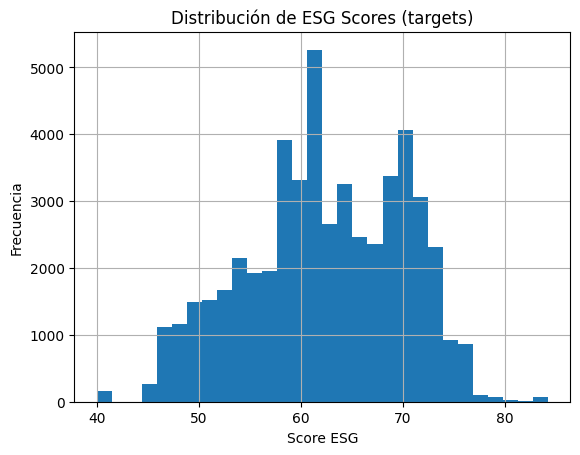

In [ ]:
plt.hist(y_filtered, bins=30)
plt.title("Distribución de ESG Scores (targets)")
plt.xlabel("Score ESG")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [ ]:
output_filtered_path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/ESG_TRAIN_READY_2.pkl"

with open(output_filtered_path, "wb") as f:
    pickle.dump({
        "X": X_filtered,
        "y": y_filtered,
        "tickers": tickers_filtered,
        "categories": categories_filtered,
        "target_dates": dates_filtered
    }, f)